# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

Мы научимся обрабатывать пропуски в данных для количественных (числовых) и категориальных признаков и масштабировать данные. Также мы научимся преобразовывать категориальные признаки в числовые.

## В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

# Загрузка и первичный анализ данных

Используем данные из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).

In [2]:
# Будем использовать только обучающую выборку
data1 = pd.read_csv('googleplaystore.csv', sep=",")

In [3]:
# размер набора данных
data1.shape

(1459, 80)

In [4]:
# типы колонок
data1.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

In [5]:
# проверим есть ли пропущенные значения
data1.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [6]:
# Первые 5 строк датасета
data1.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
total_count1 = data1.shape[0]
print('Всего строк: {}'.format(total_count1))

Всего строк: 1459


## Обработка пропусков в данных
### Простые стратегии - удаление или заполнение нулями

Удаление колонок, содержащих пустые значения res = data.dropna(axis=1, how='any')

Удаление строк, содержащих пустые значения res = data.dropna(axis=0, how='any')

In [8]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data1.columns:
    # Количество пустых значений 
    temp_null_count = data1[data1[col].isnull()].shape[0]
    dt = str(data1[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count1) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка LotFrontage. Тип данных float64. Количество пустых значений 227, 15.56%.
Колонка MasVnrArea. Тип данных float64. Количество пустых значений 15, 1.03%.
Колонка BsmtFinSF1. Тип данных float64. Количество пустых значений 1, 0.07%.
Колонка BsmtFinSF2. Тип данных float64. Количество пустых значений 1, 0.07%.
Колонка BsmtUnfSF. Тип данных float64. Количество пустых значений 1, 0.07%.
Колонка TotalBsmtSF. Тип данных float64. Количество пустых значений 1, 0.07%.
Колонка BsmtFullBath. Тип данных float64. Количество пустых значений 2, 0.14%.
Колонка BsmtHalfBath. Тип данных float64. Количество пустых значений 2, 0.14%.
Колонка GarageYrBlt. Тип данных float64. Количество пустых значений 78, 5.35%.
Колонка GarageCars. Тип данных float64. Количество пустых значений 1, 0.07%.
Колонка GarageArea. Тип данных float64. Количество пустых значений 1, 0.07%.


In [9]:
# Фильтр по колонкам с пропущенными значениями
data_num = data1[num_cols]
data_num

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
0,80.0,0.0,468.0,144.0,270.0,882.0,0.0,0.0,1961.0,1.0,730.0
1,81.0,108.0,923.0,0.0,406.0,1329.0,0.0,0.0,1958.0,1.0,312.0
2,74.0,0.0,791.0,0.0,137.0,928.0,0.0,0.0,1997.0,2.0,482.0
3,78.0,20.0,602.0,0.0,324.0,926.0,0.0,0.0,1998.0,2.0,470.0
4,43.0,0.0,263.0,0.0,1017.0,1280.0,0.0,0.0,1992.0,2.0,506.0
...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,0.0,0.0,0.0,546.0,546.0,0.0,0.0,NaN,0.0,0.0
1455,21.0,0.0,252.0,0.0,294.0,546.0,0.0,0.0,1970.0,1.0,286.0
1456,160.0,0.0,1224.0,0.0,0.0,1224.0,1.0,0.0,1960.0,2.0,576.0
1457,62.0,0.0,337.0,0.0,575.0,912.0,0.0,1.0,NaN,0.0,0.0


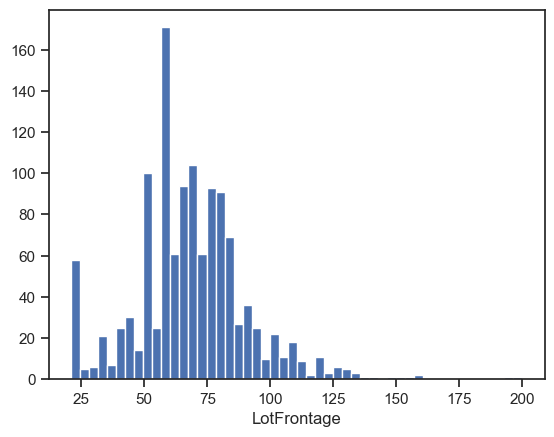

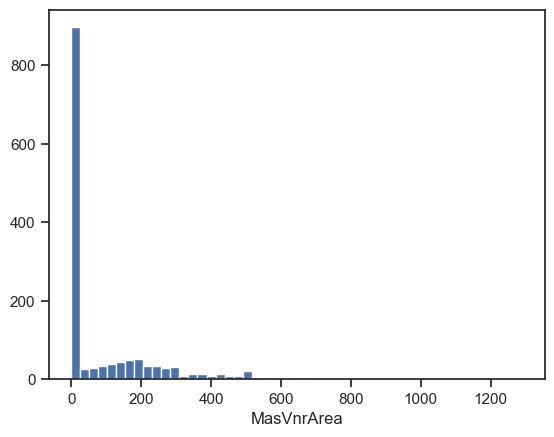

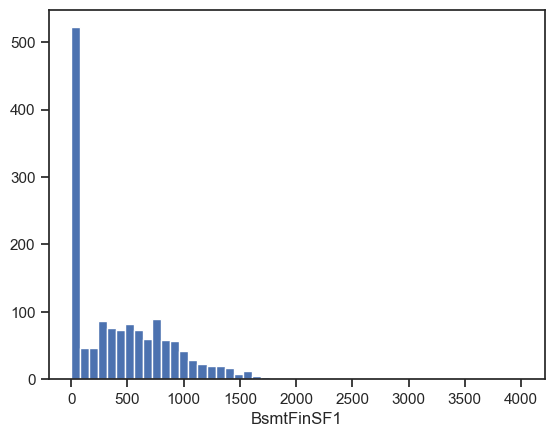

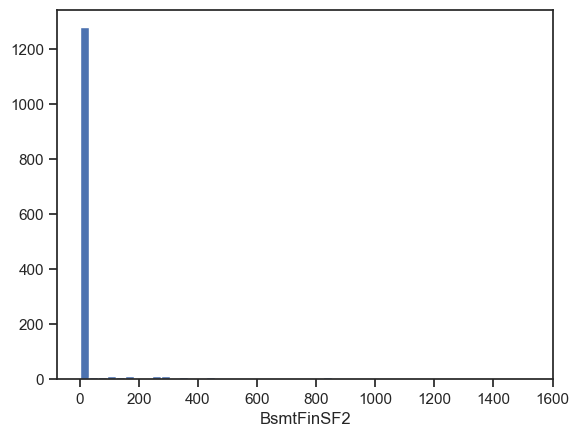

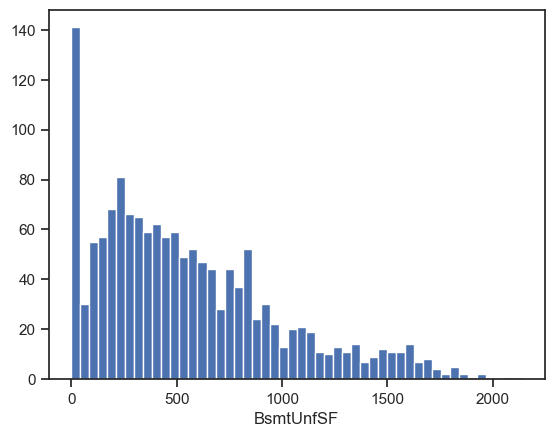

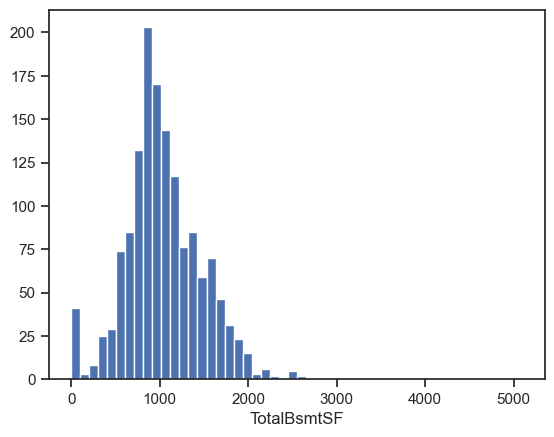

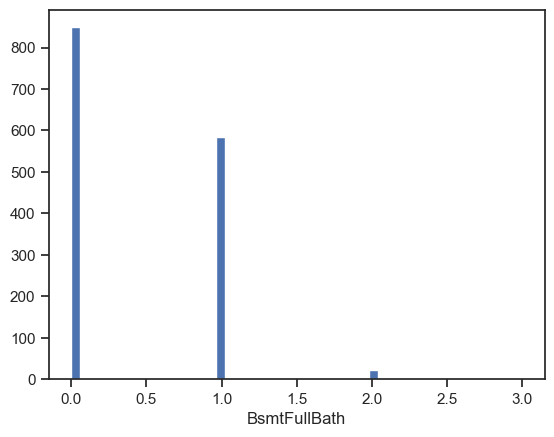

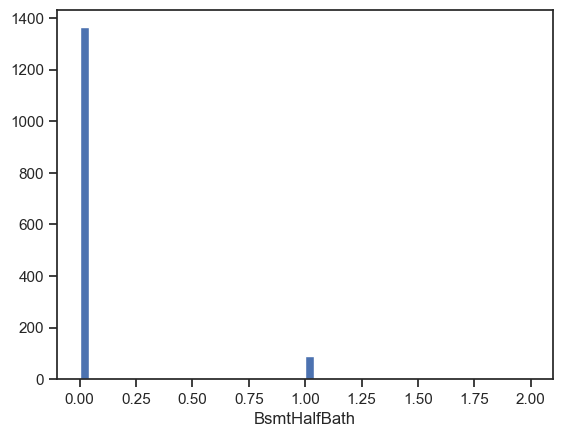

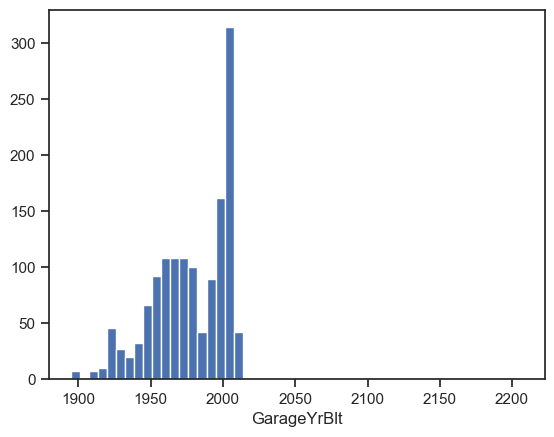

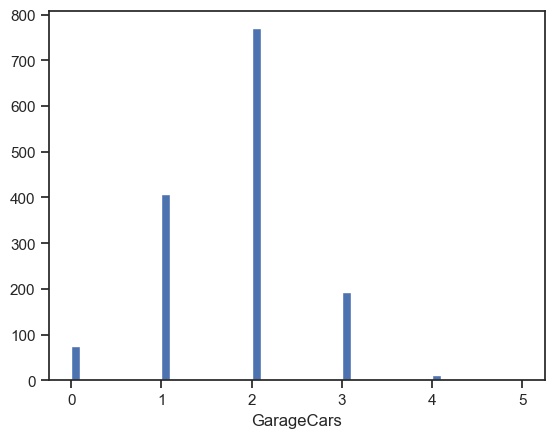

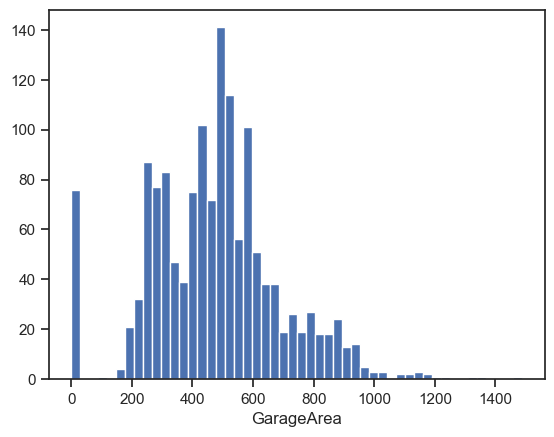

In [10]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data1[col], 50)
    plt.xlabel(col)
    plt.show()

In [11]:
data_num_MasVnrArea = data_num[['MasVnrArea']]
data_num_MasVnrArea.head()

,MasVnrArea
0,0.0
1,108.0
2,0.0
3,20.0
4,0.0


In [12]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [13]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_MasVnrArea)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [14]:
strategies=['mean', 'median', 'most_frequent']

In [15]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_MasVnrArea)
    return data_num_imp[mask_missing_values_only]

In [16]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([100.70914127, 100.70914127, 100.70914127, 100.70914127,
        100.70914127, 100.70914127, 100.70914127, 100.70914127,
        100.70914127, 100.70914127, 100.70914127, 100.70914127,
        100.70914127, 100.70914127, 100.70914127]))

In [17]:
strategies[1], test_num_impute(strategies[1])

('median', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [18]:
strategies[2], test_num_impute(strategies[2])

C:\Users\user\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


('most_frequent',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [19]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [20]:
data1[['GarageYrBlt']].describe()

,GarageYrBlt
count,1381.000000
mean,1977.721217
std,26.431175
min,1895.000000
25%,1959.000000
50%,1979.000000
75%,2002.000000
max,2207.000000


In [21]:
test_num_impute_col(data1, 'GarageYrBlt', strategies[0])

('GarageYrBlt', 'mean', 78, 1977.7212165097756, 1977.7212165097756)

In [22]:
test_num_impute_col(data1, 'GarageYrBlt', strategies[1])

('GarageYrBlt', 'median', 78, 1979.0, 1979.0)

In [23]:
test_num_impute_col(data1, 'GarageYrBlt', strategies[2])

C:\Users\user\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


('GarageYrBlt', 'most_frequent', 78, 2005.0, 2005.0)

## Обработка пропусков в категориальных данных

In [1]:
data2 = pd.read_csv('googleplaystore.csv', sep=",", encoding='latin-1')

NameError: name 'pd' is not defined

In [25]:
# размер набора данных
data2.shape

(234, 12)

In [26]:
# типы колонок
data2.dtypes

Country or Dependency    object
Population(2020)         object
Yearly Change            object
Net Change               object
Density(p/km^2)          object
Land Area(km^2)          object
Migrants                 object
Fert Rate                object
Med Age                  object
Urban                    object
World Share              object
Regions                  object
dtype: object

In [27]:
# проверим есть ли пропущенные значения
data2.isnull().sum()

Country or Dependency     0
Population(2020)          0
Yearly Change             0
Net Change                0
Density(p/km^2)           0
Land Area(km^2)           0
Migrants                 33
Fert Rate                 0
Med Age                   0
Urban                     0
World Share               0
Regions                   0
dtype: int64

In [28]:
# Первые 5 строк датасета
data2.head()

,Country or Dependency,Population(2020),Yearly Change,Net Change,Density(p/km^2),Land Area(km^2),Migrants,Fert Rate,Med Age,Urban,World Share,Regions
0,China,"1,439,323,776",0.39%,"5,540,090",153,"9,388,211","-348,399",1.7,38,61%,18.47%,Asia
1,India,"1,380,004,385",0.99%,"13,586,631",464,"2,973,190","-532,687",2.2,28,35%,17.70%,Asia
2,Indonesia,"273,523,615",1.07%,"2,898,047",151,"1,811,570","-98,955",2.3,30,56%,3.51%,Asia
3,Pakistan,"220,892,340",2.00%,"4,327,022",287,"770,880","-233,379",3.6,23,35%,2.83%,Asia
4,Bangladesh,"164,689,383",1.01%,"1,643,222","1,265","130,170","-369,501",2.1,28,39%,2.11%,Asia


In [29]:
total_count2 = data2.shape[0]
print('Всего строк: {}'.format(total_count2))

Всего строк: 234


In [30]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data2.columns:
    # Количество пустых значений 
    temp_null_count = data2[data2[col].isnull()].shape[0]
    dt = str(data2[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count2) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Migrants. Тип данных object. Количество пустых значений 33, 14.1%.


In [31]:
cat_temp_data = data2[['Migrants']]
cat_temp_data.head()

,Migrants
0,"-348,399"
1,"-532,687"
2,"-98,955"
3,"-233,379"
4,"-369,501"


In [32]:
cat_temp_data['Migrants'].unique()

array(['-348,399', '-532,687', '-98,955', '-233,379', '-369,501',
       '71,560', '-67,152', '-80,000', '283,922', '-55,000', '19,444',
       '-163,313', '11,731', '7,834', '-62,920', '134,979', '-8,863',
       '50,000', '-30,000', '41,710', '-5,403', '30,001', '-97,986',
       '-18,000', '-427,391', '10,220', '1,200', '40,000', '-20,000',
       '10,000', '29,308', '-14,704', '-30,012', '-4,000', '-5,000',
       '27,028', '-10,563', '87,400', '39,520', '-10,000', '-852',
       '-4,998', '47,800', '-5,385', '5,000', '320', '11,370', '0',
       '-60,000', '30,000', '-38,033', '23,861', '145,405', '-40,076',
       '168,694', '-50,000', '-51,419', '6,413', '-1,500', '-4,800',
       '-8,000', '4,000', '-25,000', '-40,000', '-16,053', '2,000',
       '-116,858', '-9,000', '-2,000', '2,001', '-174,200', '-4,200',
       '-1,999', '-39,858', '-4,806', '-3,087', '3,000', '3,260',
       '-10,047', '-1,399', '16,000', '-8,353', '900', '-1,256', '5,582',
       '-1,342', '-1,680', '-200

In [33]:
cat_temp_data[cat_temp_data['Migrants'].isnull()].shape

(33, 1)

In [34]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['-348,399'],
       ['-532,687'],
       ['-98,955'],
       ['-233,379'],
       ['-369,501'],
       ['71,560'],
       ['-67,152'],
       ['-80,000'],
       ['283,922'],
       ['-55,000'],
       ['19,444'],
       ['-163,313'],
       ['11,731'],
       ['7,834'],
       ['-62,920'],
       ['134,979'],
       ['-8,863'],
       ['50,000'],
       ['-30,000'],
       ['41,710'],
       ['-5,403'],
       ['30,001'],
       ['-97,986'],
       ['-18,000'],
       ['-427,391'],
       ['-30,000'],
       ['10,220'],
       ['1,200'],
       ['40,000'],
       ['-20,000'],
       ['10,000'],
       ['29,308'],
       ['-14,704'],
       ['-30,012'],
       ['-4,000'],
       ['-5,000'],
       ['27,028'],
       ['-10,563'],
       ['87,400'],
       ['39,520'],
       ['-10,000'],
       ['-852'],
       ['-4,998'],
       ['40,000'],
       ['47,800'],
       ['-5,385'],
       ['5,000'],
       ['320'],
       ['5,000'],
       ['11,370'],
       ['0'],
       ['-60,000'

In [35]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['-1,000', '-1,256', '-1,342', '-1,387', '-1,399', '-1,440',
       '-1,500', '-1,600', '-1,680', '-1,999', '-10,000', '-10,047',
       '-10,563', '-11,332', '-116,858', '-14,000', '-14,400', '-14,704',
       '-14,837', '-16,000', '-16,053', '-16,556', '-163,313', '-174,200',
       '-18,000', '-2,000', '-2,803', '-2,957', '-20,000', '-200',
       '-21,272', '-21,585', '-233,379', '-25,000', '-29,395', '-3,000',
       '-3,087', '-30,000', '-30,012', '-32,780', '-348,399', '-35,000',
       '-369,501', '-38,033', '-39,858', '-4,000', '-4,200', '-4,800',
       '-4,806', '-4,998', '-40,000', '-40,076', '-40,539', '-427,391',
       '-451', '-480', '-5,000', '-5,385', '-5,403', '-50,000', '-506',
       '-51,419', '-532,687', '-55,000', '-6,000', '-6,202', '-6,800',
       '-60,000', '-62,920', '-653,249', '-67,152', '-73,999', '-79',
       '-8,000', '-8,001', '-8,353', '-8,863', '-80,000', '-800', '-852',
       '-9,000', '-9,215', '-9,504', '-960', '-97,986', '-98,955', '0',


In [36]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['-348,399'],
       ['-532,687'],
       ['-98,955'],
       ['-233,379'],
       ['-369,501'],
       ['71,560'],
       ['-67,152'],
       ['-80,000'],
       ['283,922'],
       ['-55,000'],
       ['19,444'],
       ['-163,313'],
       ['11,731'],
       ['7,834'],
       ['-62,920'],
       ['134,979'],
       ['-8,863'],
       ['50,000'],
       ['-30,000'],
       ['41,710'],
       ['-5,403'],
       ['30,001'],
       ['-97,986'],
       ['-18,000'],
       ['-427,391'],
       ['-30,000'],
       ['10,220'],
       ['1,200'],
       ['40,000'],
       ['-20,000'],
       ['10,000'],
       ['29,308'],
       ['-14,704'],
       ['-30,012'],
       ['-4,000'],
       ['-5,000'],
       ['27,028'],
       ['-10,563'],
       ['87,400'],
       ['39,520'],
       ['-10,000'],
       ['-852'],
       ['-4,998'],
       ['40,000'],
       ['47,800'],
       ['-5,385'],
       ['5,000'],
       ['320'],
       ['5,000'],
       ['11,370'],
       ['0'],
       ['-60,000'

In [37]:
np.unique(data_imp3)

array(['-1,000', '-1,256', '-1,342', '-1,387', '-1,399', '-1,440',
       '-1,500', '-1,600', '-1,680', '-1,999', '-10,000', '-10,047',
       '-10,563', '-11,332', '-116,858', '-14,000', '-14,400', '-14,704',
       '-14,837', '-16,000', '-16,053', '-16,556', '-163,313', '-174,200',
       '-18,000', '-2,000', '-2,803', '-2,957', '-20,000', '-200',
       '-21,272', '-21,585', '-233,379', '-25,000', '-29,395', '-3,000',
       '-3,087', '-30,000', '-30,012', '-32,780', '-348,399', '-35,000',
       '-369,501', '-38,033', '-39,858', '-4,000', '-4,200', '-4,800',
       '-4,806', '-4,998', '-40,000', '-40,076', '-40,539', '-427,391',
       '-451', '-480', '-5,000', '-5,385', '-5,403', '-50,000', '-506',
       '-51,419', '-532,687', '-55,000', '-6,000', '-6,202', '-6,800',
       '-60,000', '-62,920', '-653,249', '-67,152', '-73,999', '-79',
       '-8,000', '-8,001', '-8,353', '-8,863', '-80,000', '-800', '-852',
       '-9,000', '-9,215', '-9,504', '-960', '-97,986', '-98,955', '0',


In [38]:
data_imp3[data_imp3=='NA'].size

33

# Преобразование категориальных признаков в числовые

In [39]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,"-348,399"
1,"-532,687"
2,"-98,955"
3,"-233,379"
4,"-369,501"
...,...
229,0
230,0
231,0
232,0


## Кодирование категорий целочисленными значениями (label encoding)

В этом случае уникальные значения категориального признака кодируются целыми числами.

В scikit-learn для такого кодирования используется два класса :

- LabelEncoder - который ориентирован на применение к одному признаку. Этот класс прежде всего предназначен для кодирования целевого признака, но может быть также использован для последовательного кодирования отдельных нецелевых признаков.
- OrdinalEncoder - который ориентирован на применение к матрице объект-признак, то есть для кодирования матрицы нецелевых признаков.

### Использование LabelEncoder

In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
cat_enc['c1'].unique()

array(['-348,399', '-532,687', '-98,955', '-233,379', '-369,501',
       '71,560', '-67,152', '-80,000', '283,922', '-55,000', '19,444',
       '-163,313', '11,731', '7,834', '-62,920', '134,979', '-8,863',
       '50,000', '-30,000', '41,710', '-5,403', '30,001', '-97,986',
       '-18,000', '-427,391', '10,220', '1,200', '40,000', '-20,000',
       '10,000', '29,308', '-14,704', '-30,012', '-4,000', '-5,000',
       '27,028', '-10,563', '87,400', '39,520', '-10,000', '-852',
       '-4,998', '47,800', '-5,385', '5,000', '320', '11,370', '0',
       '-60,000', '30,000', '-38,033', '23,861', '145,405', '-40,076',
       '168,694', '-50,000', '-51,419', '6,413', '-1,500', '-4,800',
       '-8,000', '4,000', '-25,000', '-40,000', '-16,053', '2,000',
       '-116,858', '-9,000', '-2,000', '2,001', '-174,200', '-4,200',
       '-1,999', '-39,858', '-4,806', '-3,087', '3,000', '3,260',
       '-10,047', '-1,399', '16,000', '-8,353', '900', '-1,256', '5,582',
       '-1,342', '-1,680', '-200

In [42]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [43]:
# Наименования категорий в соответствии с порядковыми номерами

# Свойство называется classes, потому что предполагается что мы решаем 
# задачу классификации и каждое значение категории соответствует 
# какому-либо классу целевого признака

le.classes_

array(['-1,000', '-1,256', '-1,342', '-1,387', '-1,399', '-1,440',
       '-1,500', '-1,600', '-1,680', '-1,999', '-10,000', '-10,047',
       '-10,563', '-11,332', '-116,858', '-14,000', '-14,400', '-14,704',
       '-14,837', '-16,000', '-16,053', '-16,556', '-163,313', '-174,200',
       '-18,000', '-2,000', '-2,803', '-2,957', '-20,000', '-200',
       '-21,272', '-21,585', '-233,379', '-25,000', '-29,395', '-3,000',
       '-3,087', '-30,000', '-30,012', '-32,780', '-348,399', '-35,000',
       '-369,501', '-38,033', '-39,858', '-4,000', '-4,200', '-4,800',
       '-4,806', '-4,998', '-40,000', '-40,076', '-40,539', '-427,391',
       '-451', '-480', '-5,000', '-5,385', '-5,403', '-50,000', '-506',
       '-51,419', '-532,687', '-55,000', '-6,000', '-6,202', '-6,800',
       '-60,000', '-62,920', '-653,249', '-67,152', '-73,999', '-79',
       '-8,000', '-8,001', '-8,353', '-8,863', '-80,000', '-800', '-852',
       '-9,000', '-9,215', '-9,504', '-960', '-97,986', '-98,955', '0',


In [44]:
cat_enc_le

array([ 40,  62,  85,  32,  42, 151,  70,  77, 121,  63, 108,  22,  95,
       150,  68,  98,  76, 142,  37, 137,  58, 127,  84,  24,  53,  37,
        92,  88, 136,  28,  91, 122,  17,  38,  45,  56, 119,  12, 153,
       132,  10,  79,  49, 136, 138,  57, 140, 128, 140,  94,  86,  67,
       126,  43, 116, 101,  51,  10, 106,  10,  59,  61, 148,  10,  56,
         6,  47,  73, 133,  33,  50,  20,  73,  28, 109,  50,  14,  45,
        80,  25,  45, 110,  23,  25,  46,   9,  45,  56,  50, 140,  44,
        48,  36, 123, 124,  11,   4, 105,  86,  75, 155,   1,  25, 141,
         2,  86,   8,  29,  86, 107, 146, 118, 130, 102, 136,  91,  34,
        71, 105, 139, 114,  19,  64, 136, 147, 152, 149, 133, 145,  47,
       103,  99,  90, 120, 115,  74,   3,  31,  15,  39,   0, 109,  18,
       125,  55, 154, 155, 131,  89,  86,  86,  86,  86,  86,  86,  86,
        86, 113,  67, 112, 135, 157,  69,  96,  81, 129,  82,  16,  41,
        37,  66,  21,  30,  52, 134,  93,  35,  13,  84,  78,  6

In [45]:
np.unique(cat_enc_le)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157])

In [46]:
# В этом примере видно, что перед кодированием 
# уникальные значения признака сортируются в лексикографиеском порядке
le.inverse_transform([0, 1, 2, 3])

array(['-1,000', '-1,256', '-1,342', '-1,387'], dtype=object)

### Использование OrdinalEncoder

In [47]:
from sklearn.preprocessing import OrdinalEncoder

In [48]:
data_oe = data2[['Migrants']]
data_oe.head()

,Migrants
0,"-348,399"
1,"-532,687"
2,"-98,955"
3,"-233,379"
4,"-369,501"


In [49]:
imp4 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_oe_filled = imp4.fit_transform(data_oe)
data_oe_filled

array([['-348,399'],
       ['-532,687'],
       ['-98,955'],
       ['-233,379'],
       ['-369,501'],
       ['71,560'],
       ['-67,152'],
       ['-80,000'],
       ['283,922'],
       ['-55,000'],
       ['19,444'],
       ['-163,313'],
       ['11,731'],
       ['7,834'],
       ['-62,920'],
       ['134,979'],
       ['-8,863'],
       ['50,000'],
       ['-30,000'],
       ['41,710'],
       ['-5,403'],
       ['30,001'],
       ['-97,986'],
       ['-18,000'],
       ['-427,391'],
       ['-30,000'],
       ['10,220'],
       ['1,200'],
       ['40,000'],
       ['-20,000'],
       ['10,000'],
       ['29,308'],
       ['-14,704'],
       ['-30,012'],
       ['-4,000'],
       ['-5,000'],
       ['27,028'],
       ['-10,563'],
       ['87,400'],
       ['39,520'],
       ['-10,000'],
       ['-852'],
       ['-4,998'],
       ['40,000'],
       ['47,800'],
       ['-5,385'],
       ['5,000'],
       ['320'],
       ['5,000'],
       ['11,370'],
       ['0'],
       ['-60,000'

In [50]:
oe = OrdinalEncoder()
cat_enc_oe = oe.fit_transform(data_oe_filled)
cat_enc_oe

array([[ 40.],
       [ 62.],
       [ 85.],
       [ 32.],
       [ 42.],
       [151.],
       [ 70.],
       [ 77.],
       [121.],
       [ 63.],
       [108.],
       [ 22.],
       [ 95.],
       [150.],
       [ 68.],
       [ 98.],
       [ 76.],
       [142.],
       [ 37.],
       [137.],
       [ 58.],
       [127.],
       [ 84.],
       [ 24.],
       [ 53.],
       [ 37.],
       [ 92.],
       [ 88.],
       [136.],
       [ 28.],
       [ 91.],
       [122.],
       [ 17.],
       [ 38.],
       [ 45.],
       [ 56.],
       [119.],
       [ 12.],
       [153.],
       [132.],
       [ 10.],
       [ 79.],
       [ 49.],
       [136.],
       [138.],
       [ 57.],
       [140.],
       [128.],
       [140.],
       [ 94.],
       [ 86.],
       [ 67.],
       [126.],
       [ 43.],
       [116.],
       [101.],
       [ 51.],
       [ 10.],
       [106.],
       [ 10.],
       [ 59.],
       [ 61.],
       [148.],
       [ 10.],
       [ 56.],
       [  6.],
       [ 4

In [51]:
# Уникальные значения 1 признака
np.unique(cat_enc_oe[:, 0])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [52]:
# Наименования категорий в соответствии с порядковыми номерами
oe.categories_

[array(['-1,000', '-1,256', '-1,342', '-1,387', '-1,399', '-1,440',
        '-1,500', '-1,600', '-1,680', '-1,999', '-10,000', '-10,047',
        '-10,563', '-11,332', '-116,858', '-14,000', '-14,400', '-14,704',
        '-14,837', '-16,000', '-16,053', '-16,556', '-163,313', '-174,200',
        '-18,000', '-2,000', '-2,803', '-2,957', '-20,000', '-200',
        '-21,272', '-21,585', '-233,379', '-25,000', '-29,395', '-3,000',
        '-3,087', '-30,000', '-30,012', '-32,780', '-348,399', '-35,000',
        '-369,501', '-38,033', '-39,858', '-4,000', '-4,200', '-4,800',
        '-4,806', '-4,998', '-40,000', '-40,076', '-40,539', '-427,391',
        '-451', '-480', '-5,000', '-5,385', '-5,403', '-50,000', '-506',
        '-51,419', '-532,687', '-55,000', '-6,000', '-6,202', '-6,800',
        '-60,000', '-62,920', '-653,249', '-67,152', '-73,999', '-79',
        '-8,000', '-8,001', '-8,353', '-8,863', '-80,000', '-800', '-852',
        '-9,000', '-9,215', '-9,504', '-960', '-97,986', '-

In [53]:
# Обратное преобразование
oe.inverse_transform(cat_enc_oe)

array([['-348,399'],
       ['-532,687'],
       ['-98,955'],
       ['-233,379'],
       ['-369,501'],
       ['71,560'],
       ['-67,152'],
       ['-80,000'],
       ['283,922'],
       ['-55,000'],
       ['19,444'],
       ['-163,313'],
       ['11,731'],
       ['7,834'],
       ['-62,920'],
       ['134,979'],
       ['-8,863'],
       ['50,000'],
       ['-30,000'],
       ['41,710'],
       ['-5,403'],
       ['30,001'],
       ['-97,986'],
       ['-18,000'],
       ['-427,391'],
       ['-30,000'],
       ['10,220'],
       ['1,200'],
       ['40,000'],
       ['-20,000'],
       ['10,000'],
       ['29,308'],
       ['-14,704'],
       ['-30,012'],
       ['-4,000'],
       ['-5,000'],
       ['27,028'],
       ['-10,563'],
       ['87,400'],
       ['39,520'],
       ['-10,000'],
       ['-852'],
       ['-4,998'],
       ['40,000'],
       ['47,800'],
       ['-5,385'],
       ['5,000'],
       ['320'],
       ['5,000'],
       ['11,370'],
       ['0'],
       ['-60,000'

### Проблемы использования LabelEncoder и OrdinalEncoder
Необходимо отметить, что LabelEncoder и OrdinalEncoder могут использоваться только для категориальных признаков в номинальных шкалах (для которых отсутствует порядок), например города, страны, названия рек и т.д.

Это связано с тем, что задать какой-либо порядок при кодировании с помощью LabelEncoder и OrdinalEncoder невозможно, они сортируют категории в лексикографическом порядке.

При этом кодирование целыми числами создает фиктивное отношение порядка (1 < 2 < 3 < ...) которого не было в исходных номинальных шкалах. Данное отношение порядка может негативно повлиять на построение модели машинного обучения.

### Кодирование шкал порядка
Библиотека scikit-learn не предоставляет готового решения для кодирования шкал порядка, но можно воспользоваться функцией map для отдельных объектов Series.

In [54]:
# пример шкалы порядка 'small' < 'medium' < 'large'
sizes = ['small', 'medium', 'large', 'small', 'medium', 'large', 'small', 'medium', 'large']

In [55]:
pd_sizes = pd.DataFrame(data={'sizes':sizes})
pd_sizes

,sizes
0,small
1,medium
2,large
3,small
4,medium
5,large
6,small
7,medium
8,large


In [56]:
pd_sizes['sizes_codes'] = pd_sizes['sizes'].map({'small':1, 'medium':2, 'large':3})
pd_sizes

,sizes,sizes_codes
0,small,1
1,medium,2
2,large,3
3,small,1
4,medium,2
5,large,3
6,small,1
7,medium,2
8,large,3


In [57]:
pd_sizes['sizes_decoded'] = pd_sizes['sizes_codes'].map({1:'small', 2:'medium', 3:'large'})
pd_sizes

,sizes,sizes_codes,sizes_decoded
0,small,1,small
1,medium,2,medium
2,large,3,large
3,small,1,small
4,medium,2,medium
5,large,3,large
6,small,1,small
7,medium,2,medium
8,large,3,large


### Кодирование категорий наборами бинарных значений - one-hot encoding
В этом случае каждое уникальное значение признака становится новым отдельным признаком.

In [58]:
from sklearn.preprocessing import OneHotEncoder

In [59]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [60]:
cat_enc.shape

(234, 1)

In [61]:
cat_enc_ohe.shape

(234, 158)

In [62]:
cat_enc_ohe

<234x158 sparse matrix of type '<class 'numpy.float64'>'
	with 234 stored elements in Compressed Sparse Row format>

In [63]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
cat_enc.head(10)

,c1
0,"-348,399"
1,"-532,687"
2,"-98,955"
3,"-233,379"
4,"-369,501"
5,"71,560"
6,"-67,152"
7,"-80,000"
8,"283,922"
9,"-55,000"


### Pandas get_dummies - быстрый вариант one-hot кодирования

In [65]:
pd.get_dummies(cat_enc).head()

,"c1_-1,000","c1_-1,256","c1_-1,342","c1_-1,387","c1_-1,399","c1_-1,440","c1_-1,500","c1_-1,600","c1_-1,680","c1_-1,999",...,"c1_6,413","c1_65,000","c1_7,834","c1_71,560","c1_8,730","c1_87,400","c1_9,741",c1_900,"c1_954,806","c1_99,069"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,"Migrants_-1,000","Migrants_-1,256","Migrants_-1,342","Migrants_-1,387","Migrants_-1,399","Migrants_-1,440","Migrants_-1,500","Migrants_-1,600","Migrants_-1,680","Migrants_-1,999",...,"Migrants_65,000","Migrants_7,834","Migrants_71,560","Migrants_8,730","Migrants_87,400","Migrants_9,741",Migrants_900,"Migrants_954,806","Migrants_99,069",Migrants_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## MinMax масштабирование

In [68]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data1[['MasVnrArea']])

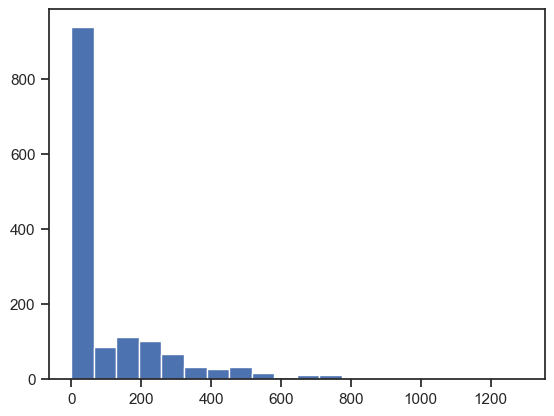

In [69]:
plt.hist(data1['MasVnrArea'], 20)
plt.show()

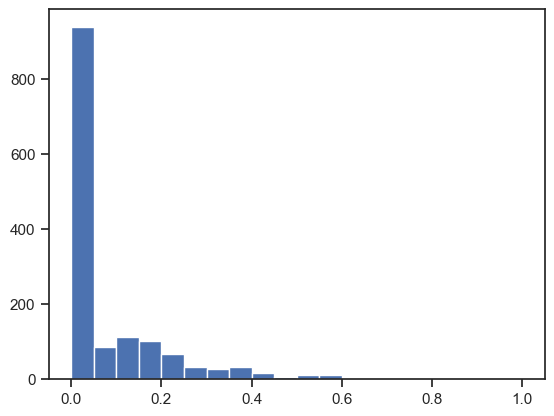

In [70]:
plt.hist(sc1_data, 20)
plt.show()

## Масштабирование данных на основе Z-оценки - StandardScaler

In [71]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data1[['MasVnrArea']])

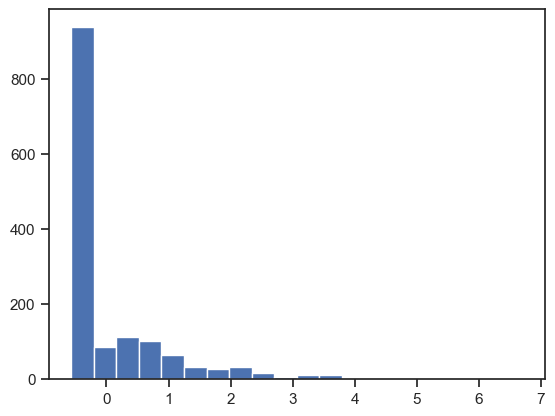

In [72]:
plt.hist(sc2_data, 20)
plt.show()